In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model as evaluate_model

In [2]:
!pip list|grep kaggle

kaggle                                1.7.4.5
kagglehub                             0.3.12


In [3]:
import json
#username和key改为自己的kaggle的，如果不行，就可以直接用这个
token = {"username":"cskaoyan","key":"b9aafd6b35a0953f67bfe6a18d32117a"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)#json.dump类似于write,比write方便在于可以直接把字典类型数据，变为字符串写入文件

In [4]:
!cat /content/kaggle.json

{"username": "cskaoyan", "key": "b9aafd6b35a0953f67bfe6a18d32117a"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle datasets download -d slothkong/10-monkey-species

Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
 92% 503M/547M [00:06<00:00, 120MB/s] 
100% 547M/547M [00:06<00:00, 87.2MB/s]


In [7]:
!ls -lh datasets/slothkong/10-monkey-species/

total 548M
-rw-r--r-- 1 root root 548M Sep 26  2019 10-monkey-species.zip


In [8]:
!pwd

/content


In [9]:
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip

Archive:  /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip
  inflating: /content/monkey_labels.txt  
  inflating: /content/training/training/n0/n0018.jpg  
  inflating: /content/training/training/n0/n0019.jpg  
  inflating: /content/training/training/n0/n0020.jpg  
  inflating: /content/training/training/n0/n0021.jpg  
  inflating: /content/training/training/n0/n0022.jpg  
  inflating: /content/training/training/n0/n0023.jpg  
  inflating: /content/training/training/n0/n0024.jpg  
  inflating: /content/training/training/n0/n0025.jpg  
  inflating: /content/training/training/n0/n0026.jpg  
  inflating: /content/training/training/n0/n0027.jpg  
  inflating: /content/training/training/n0/n0028.jpg  
  inflating: /content/training/training/n0/n0029.jpg  
  inflating: /content/training/training/n0/n0030.jpg  
  inflating: /content/training/training/n0/n0031.jpg  
  inflating: /content/training/training/n0/n0032.jpg  
  inflating: /content/training/training/n0/n0033.jpg  


In [10]:
!ls training/training/

n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


# 加载数据并处理为tensor

In [14]:
from pathlib import Path

DATA_DIR = Path("./")

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用ImageFolder加载数据
# ImageFolder假设数据集按照如下方式组织：root/class/image.jpg
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training/training',
    transform=data_transforms['training']
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation/validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 224，224]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 224, 224])
标签: 0 (类别: n0)


# 自定义数据集类，继承ImageFolder

In [33]:
from pathlib import Path

DATA_DIR = Path("./")

# 自定义数据集类，继承ImageFolder
class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)


# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        # transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2129, 0.2075, 0.2037])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        # transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2129, 0.2075, 0.2037])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用自定义的MonkeyDataset加载数据
train_dataset = MonkeyDataset(
    root=DATA_DIR / 'training/training',
    transform=data_transforms['training']
)

test_dataset = MonkeyDataset(
    root=DATA_DIR / 'validation/validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 224, 224]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 224, 224])
标签: 0 (类别: n0)


# 计算train_dataset的均值和方差，做数据归一化

In [34]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
cal_mean_std(train_dataset)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))

# 创建数据加载器

In [20]:
# 创建数据加载器，
batch_size = 32
train_loader = torch.utils.data.DataLoader( # 转换为张量
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


# 搭建模型，定义CNN卷积模型

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 第一个卷积块：3通道输入，32通道输出
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 输入图像为3通道，输出32个特征图
        self.bn1 = nn.BatchNorm2d(32)  # 批归一化，32通道
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 保持通道数不变，增强特征提取
        self.bn2 = nn.BatchNorm2d(32)  # 批归一化，32通道
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化层，减小特征图尺寸

        # 第二个卷积块：32通道输入，64通道输出
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 增加通道数到64，提取更复杂特征
        self.bn3 = nn.BatchNorm2d(64)  # 批归一化，64通道
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 保持通道数不变，进一步提取特征
        self.bn4 = nn.BatchNorm2d(64)  # 批归一化，64通道

        # 第三个卷积块：64通道输入，128通道输出
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 增加通道数到128，提取高级特征
        self.bn5 = nn.BatchNorm2d(128)  # 批归一化，128通道
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # 保持通道数不变，进一步提取特征
        self.bn6 = nn.BatchNorm2d(128)  # 批归一化，128通道

        # 全连接层
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # 将特征图展平后连接到256个神经元
        self.bn_fc1 = nn.BatchNorm1d(256)  # 全连接层批归一化
        self.dropout = nn.Dropout(0.2) # 添加Dropout层，防止过拟合
        self.fc2 = nn.Linear(256, 10)  # 输出层，10个类别（猴子种类）

        # 初始化网络权重
        self.init_weights()

    def init_weights(self):
        # 使用Xavier初始化方法初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # 偏置初始化为0

    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        x = self.bn1(x)  # 批归一化
        x = F.relu(x)    # 激活
        x = self.conv2(x)
        x = self.bn2(x)  # 批归一化
        x = F.relu(x)    # 激活
        x = self.pool(x)  # 池化减小尺寸

        # 第二个卷积块
        x = self.conv3(x)
        x = self.bn3(x)  # 批归一化
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)  # 批归一化
        x = F.relu(x)
        x = self.pool(x)  # 池化减小尺寸

        # 第三个卷积块
        x = self.conv5(x)
        x = self.bn5(x)  # 批归一化
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)  # 批归一化
        x = F.relu(x)
        x = self.pool(x)  # 池化减小尺寸

        # 展平特征图
        x = x.view(x.size(0), -1)  # 将特征图展平为一维向量

        # 全连接层
        x = self.fc1(x)
        x = self.bn_fc1(x)  # 全连接层批归一化
        x = F.relu(x)  # 第一个全连接层后激活
        x = F.dropout(x, p=0.2, training=self.training)  # 添加Dropout层，有20%的节点被丢弃
        x = self.fc2(x)  # 输出层，不使用激活函数

        return x


# 实列化模型

In [26]:
model = CNN()

# 从train_loader获取第一个批次的数据
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 打印图像形状
print(f"图像形状: {images.shape}")
print(f"标签形状: {labels.shape}")

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)

图像形状: torch.Size([32, 3, 224, 224])
标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


# 统计各层参数量和总参数量

In [27]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量,p.numel()指参数的个数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #p.requires_grad 指参数需要求梯度

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细，named_parameters()返回一个包含模型各层名称和参数的迭代器
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

模型总参数量: 25981354

各层参数量明细:
conv1.weight: 864 参数
conv1.bias: 32 参数
bn1.weight: 32 参数
bn1.bias: 32 参数
conv2.weight: 9216 参数
conv2.bias: 32 参数
bn2.weight: 32 参数
bn2.bias: 32 参数
conv3.weight: 18432 参数
conv3.bias: 64 参数
bn3.weight: 64 参数
bn3.bias: 64 参数
conv4.weight: 36864 参数
conv4.bias: 64 参数
bn4.weight: 64 参数
bn4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
bn5.weight: 128 参数
bn5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
bn6.weight: 128 参数
bn6.bias: 128 参数
fc1.weight: 25690112 参数
fc1.bias: 256 参数
bn_fc1.weight: 256 参数
bn_fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


# 设置交叉熵损失函数，SGD优化器

In [28]:

model = CNN()

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)

# 训练模型
model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, eval_step=50)



使用设备: cuda:0
训练开始，共1750步


  0%|          | 0/1750 [00:00<?, ?it/s]

早停触发!
70.5882
早停: 在600 步


In [30]:
history['val'][-10:-1]

[{'loss': 0.8937776158837711, 'acc': 68.01470588235294, 'step': 150},
 {'loss': 0.8995979638660655, 'acc': 69.11764705882354, 'step': 200},
 {'loss': 0.8955296558492324, 'acc': 68.38235294117646, 'step': 250},
 {'loss': 0.883372450576109, 'acc': 69.11764705882354, 'step': 300},
 {'loss': 0.8739491806310766, 'acc': 70.58823529411765, 'step': 350},
 {'loss': 0.8704332534004661, 'acc': 70.58823529411765, 'step': 400},
 {'loss': 0.8859230314984041, 'acc': 68.75, 'step': 450},
 {'loss': 0.8953010755426744, 'acc': 68.01470588235294, 'step': 500},
 {'loss': 0.8800315541379592, 'acc': 67.27941176470588, 'step': 550}]

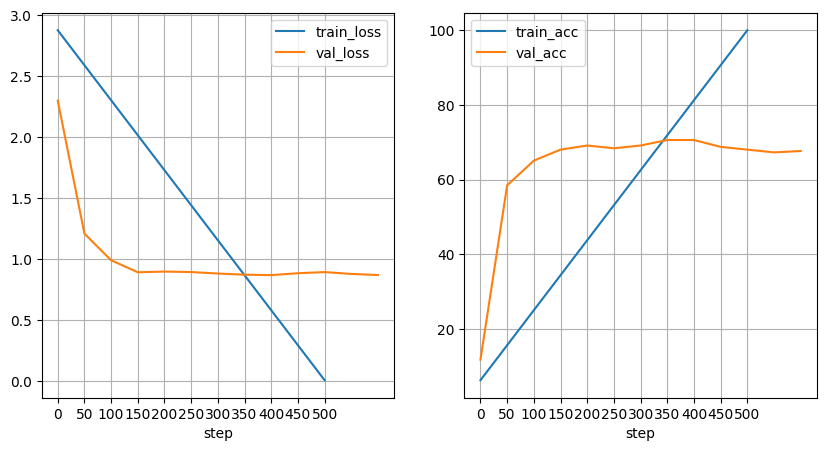

In [31]:
# 绘制学习曲线
plot_learning_curves(history, sample_step=500,eval_step=50)  #横坐标是 steps

In [32]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy

(67.6470588235294, 0.8712282145724577)